# Introduction
One-Pixel-Attack 透過更改圖片中一個相素，改變模型的預測結果。而且本文的方法是黑盒攻擊，唯一需要的資訊是模型的機率預測。運用差分進化演算法(differential evolution)，我們可以找到一個特別的點以及數值，模型預測失準，甚至誤導模型該圖片為特定目標。

以一般人來說，單一一個相素難以影響一張圖片的識別，若是大一點的圖片甚是難以察覺。而 One-Pixel-Attack 可以透過如此少的擾動，讓深度模型失效。
![](images/pred2.png "All it takes is one pixel")

| model              | parameters | test accuracy | pixels | attack success (untargeted)   | attack success (targeted) |
| ------------------ | ---------- | ------------- | ------ | ----------------------------- | ------------------------- | 
| LeNet              | 62K        | 74.9%         | 1      | 63.0%                         | 34.4%                     |
|                    |            |               | 3      | 92.0%                         | 64.4%                     |
|                    |            |               | 5      | 93.0%                         | 64.4%                     |
|                    |            |               |        |                               |                           |
| Pure CNN           | 1.4M       | 88.8%         | 1      | 13.0%                         | 6.67%                     |
|                    |            |               | 3      | 58.0%                         | 13.3%                     |
|                    |            |               | 5      | 63.0%                         | 18.9%                     |
|                    |            |               |        |                               |                           |
| Network in Network | 970K       | 90.8%         | 1      | 34.0%                         | 10.0%                     |
|                    |            |               | 3      | 73.0%                         | 24.4%                     |
|                    |            |               | 5      | 73.0%                         | 31.1%                     |
|                    |            |               |        |                               |                           |
| ResNet             | 470K       | 92.3%         | 1      | 34.0%                         | 14.4%                     |
|                    |            |               | 3      | 79.0%                         | 21.1%                     |
|                    |            |               | 5      | 79.0%                         | 22.2%                     |
|                    |            |               |        |                               |                           |
| DenseNet           | 850K       | 94.7%         | 1      | 31.0%                         | 4.44%                     |
|                    |            |               | 3      | 71.0%                         | 23.3%                     |
|                    |            |               | 5      | 69.0%                         | 28.9%                     |
|                    |            |               |        |                               |                           |
| Wide ResNet        | 11M        | 95.3%         | 1      | 19.0%                         | 1.11%                     |
|                    |            |               | 3      | 58.0%                         | 18.9%                     |
|                    |            |               | 5      | 65.0%                         | 22.2%                     |
|                    |            |               |        |                               |                           |
| CapsNet            | 12M        | 79.8%         | 1      | 19.0%                         | 0.00%                     |
|                    |            |               | 3      | 39.0%                         | 4.44%                     |
|                    |            |               | 5      | 36.0%                         | 4.44%                     |

In [12]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
from networks.resnet import ResNet

# Helper functions
import helper
from attack import PixelAttacker

In [2]:
def count_success_rate(results_table, pixel_count=1):
    df = results_table[results_table['pixels'] == pixel_count]
    return df[df['success'] == True].shape[0] / df.shape[0]

In [3]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

In [4]:
def rebuild_attack(results, round_count, pixel_count, plot=False):
    # Get img_id and table_idx of specific round_count and pixel_count
    img_id = results['image'][round_count]
    results = results[results['image'] == img_id]
    idx = results[results['pixels'] == pixel_count].index[0]

    # Get attack pixels
    pixels = results['perturbation'][idx] # [[x, y, r, g, b], ...]
    
    # Build attacked_img
    attacked_img = perturb_image(pixels, test[0][img_id])[0]
    
    if plot:
        helper.plot_image(attacked_img)
    
    return attacked_img, results['image'][idx]

# Pretained model
這次報告以cifar10作為資料集，會在cifar10上訓練 LeNet 以及 ResNet，再拿出測試資料集針對兩種網路進行攻擊。



Successfully loaded lenet
Successfully loaded resnet



以Lenet預測圖片


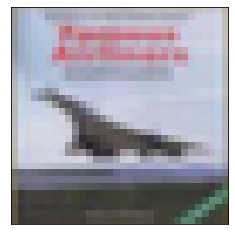

True: airplane
Predicted: airplane


以Resnet預測圖片


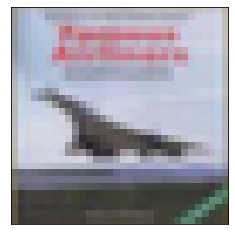

True: airplane
Predicted: airplane


In [5]:
# Load data from cifar10
_, test = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load pretrained model
models =  [LeNet(load_weights=True), ResNet(load_weights=True)]

# Show results of image predictions from different models
img_id = 3 # Image index in the test set
model = models[0]
print(f'\n\n')
print(f'以Lenet預測圖片')
prob = model.predict_one(test[0][img_id])
helper.plot_image(test[0][img_id])
print(f'True: {class_names[test[1][img_id][0]]}')
print(f'Predicted: {class_names[np.argmax(prob)]}')

model = models[1]
print(f'\n')
print(f'以Resnet預測圖片')
prob = model.predict_one(test[0][img_id])
helper.plot_image(test[0][img_id])
print(f'True: {class_names[test[1][img_id][0]]}')
print(f'Predicted: {class_names[np.argmax(prob)]}')

# Attack Results
我們事先針對 ResNet 進行 500 回攻擊，每次隨機從測試資料集中挑選一針照片，進行 one-pixel, 3-pixels, 5-pixels 攻擊，分為 targeted attack 以及 untargeted attack，指定/不指定誤導的目標，並記錄圖片資訊，預測結果，攻擊結果。


In [6]:
# Load result of previous attack
cols = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
with open('networks/results/results.pkl', 'rb') as file:
    results =pickle.load(file)
    untargeted_results = pd.DataFrame(results, columns=cols)
    
# Show data of specific rounds
rounds = 10
img_id = untargeted_results['image'][rounds]
results = untargeted_results[untargeted_results['image'] == img_id]
results

,model,pixels,image,true,predicted,success,cdiff,prior_probs,predicted_probs,perturbation
10,resnet,1,6707,2,3,True,0.731244,"[4.933282e-08, 3.3220373e-09, 0.99992204, 1.74...","[2.5830963e-05, 4.2864357e-07, 0.2686777, 0.72...","[6.6275221416225225, 20.568022556641953, 0.216..."
510,resnet,3,6707,2,3,True,0.999631,"[4.933282e-08, 3.3220373e-09, 0.99992204, 1.74...","[0.00011893081, 1.4406618e-07, 0.0002908279, 0...","[20.78556392857645, 21.841062913198154, 21.723..."
1010,resnet,5,6707,2,3,True,0.999904,"[4.933282e-08, 3.3220373e-09, 0.99992204, 1.74...","[6.137822e-06, 3.54626e-08, 1.7930786e-05, 0.9...","[7.735506971931496, 14.600379267319134, 27.040..."


In [7]:
# Load result of previous attack
with open('networks/results/targeted_results.pkl', 'rb') as file:
    results =pickle.load(file)
    targeted_results = pd.DataFrame(results, columns=cols)
    
# Show data of specific rounds
rounds = 10
img_id = targeted_results['image'][rounds]
results = targeted_results[targeted_results['image'] == img_id]
#results

In [8]:
print('-----------Targeted Results---------------\n')
print(f'1px  Attack Success Rate on ResNet: {count_success_rate(targeted_results, 1):.3f}%')
print(f'3pxs Attack Success Rate on ResNet: {count_success_rate(targeted_results, 3):.3f}%')
print(f'5pxs Attack Success Rate on ResNet: {count_success_rate(targeted_results, 5):.3f}%')
print('\n')
print('-----------Untargeted Results--------------\n')
print(f'1px  Attack Success Rate on ResNet: {count_success_rate(untargeted_results, 1):.3f}%')
print(f'3pxs Attack Success Rate on ResNet: {count_success_rate(untargeted_results, 3):.3f}%')
print(f'5pxs Attack Success Rate on ResNet: {count_success_rate(untargeted_results, 5):.3f}%')

-----------Targeted Results---------------

1px  Attack Success Rate on ResNet: 0.102%
3pxs Attack Success Rate on ResNet: 0.243%
5pxs Attack Success Rate on ResNet: 0.275%


-----------Untargeted Results--------------

1px  Attack Success Rate on ResNet: 0.308%
3pxs Attack Success Rate on ResNet: 0.738%
5pxs Attack Success Rate on ResNet: 0.762%


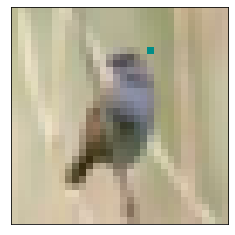

True: bird
Predicted: cat


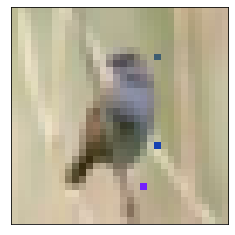

True: bird
Predicted: cat


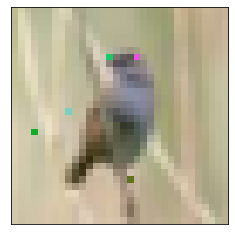

True: bird
Predicted: cat


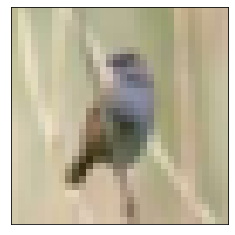

True: bird
Predicted: bird


In [9]:
model = models[1] # ResNet

# Rebuild attacked img 
attacked_img, img_id = rebuild_attack(untargeted_results, 10, 1)

# Show results of image predictions 
prob = model.predict_one(attacked_img)
helper.plot_image(attacked_img)
print(f'True: {class_names[test[1][img_id][0]]}')
print(f'Predicted: {class_names[np.argmax(prob)]}')

attacked_img, img_id = rebuild_attack(untargeted_results, 10, 3)

prob = model.predict_one(attacked_img)
helper.plot_image(attacked_img)
print(f'True: {class_names[test[1][img_id][0]]}')
print(f'Predicted: {class_names[np.argmax(prob)]}')

attacked_img, img_id = rebuild_attack(untargeted_results, 10, 5)

prob = model.predict_one(attacked_img)
helper.plot_image(attacked_img)
print(f'True: {class_names[test[1][img_id][0]]}')
print(f'Predicted: {class_names[np.argmax(prob)]}')

prob = model.predict_one(test[0][img_id])
helper.plot_image(test[0][img_id])
print(f'True: {class_names[test[1][img_id][0]]}')
print(f'Predicted: {class_names[np.argmax(prob)]}')

# Live Hacking

這裡我們構築一個 Attacker，並以 Lenet 為目標，我們可以選擇不同的照片，指定或不指定誤導的目標。透過 Attacker 建構一個可以欺騙模型的照片。

In [10]:
# Build attacker
attacker = PixelAttacker(models[:1], test, class_names)

Evaluating lenet


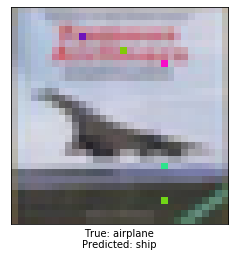

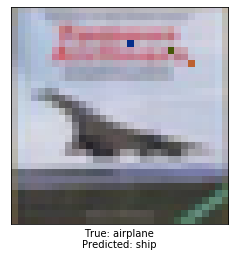

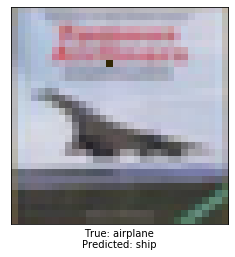

In [11]:
img_id = 3
target = None

# Attack Lenet
result = attacker.attack(img_id, models[0], target, pixel_count=5,  plot=True)
result = attacker.attack(img_id, models[0], target, pixel_count=3,  plot=True)
result = attacker.attack(img_id, models[0], target, pixel_count=1,  plot=True)